# Linear Time-Varying Kalman Filter SLAM

This notebook follows Section 4 of [1]. After a brief refresher on linear time-varying (LTV) Kalman filtering, the theory of analytical LTV KF SLAM is presented, followed by implementation details.

[1] F. Tan, W. Lohmiller, and J.-J. Slotine, “Analytical SLAM without
linearization,” The International Journal of Robotics Research, vol. 36,
no. 13-14, pp. 1554–1578, 2017


# Kalman Filtering Refresher

### Continuous-time Kalman Filter

The original formulation of the Kalman filter given by R.E. Kalman was in discrete time. The Kalman-Bucy filter is the continuous-time version of the Kalman filter. Consider the LTV state-space model

$$
\begin{align}
\dot{\mathbf{x}} &= \mathbf{A}\mathbf{x} + \mathbf{B}\mathbf{u} + \mathbf{w}(t) \\
\mathbf{y} &= \mathbf{C}\mathbf{x} + \mathbf{v}(t)
\end{align}
$$

where $\mathbf{w}(t)$, $\mathbf{v}(t)$ are Gaussian processes described by intensities $\mathbf{Q}(t)$ and $\mathbf{R}(t)$, respectively.

Then the Kalman-Bucy filter consists of the following differential equations:

$$
\begin{align}
\text{State estimate:} &\qquad \dot{\hat{\mathbf{x}}} = \mathbf{A}\hat{\mathbf{x}} + \mathbf{B}\mathbf{u} + \mathbf{K}(\mathbf{y} - \mathbf{C}\hat{\mathbf{x}}) \\
\text{Estimation covariance:} &\qquad \dot{\mathbf{P}} = \mathbf{A}\mathbf{P} + \mathbf{P}\mathbf{A}^\top + \mathbf{Q} - \mathbf{K}\mathbf{R}\mathbf{K}^\top
\end{align}
$$

where $K$ is the Kalman gain $\mathbf{K}(t) = \mathbf{P}\mathbf{C}^\top\mathbf{R}^{-1}$. The estimation covariance differential equation is a matrix Riccati equation. Notice that there is no distinction between the propagation and update steps, as in the discrete-time Kalman filter.

In implementation, these differential equations [need to be numerically integrated](https://dsp.stackexchange.com/a/23337) using, e.g., ODE45 or RK4. For a MATLAB example, see [here](https://github.com/MatthewPeterKelly/Continuous_Finite_LQR/blob/master/finiteLqr.m) and [here](https://www.mathworks.com/matlabcentral/answers/94722-how-can-i-solve-the-matrix-riccati-differential-equation-within-matlab).

### Continuous-Discrete Kalman Filter

When measurements are available at a slower rate than the simulated continuous-time dynamics, an alternate form of the Kalman filter is useful, sometimes called the Hybrid Kalman filter. Consider the following continuous-discrete dynamics

$$
\begin{align}
\dot{\mathbf{x}} &= \mathbf{A}\mathbf{x} + \mathbf{B}\mathbf{u} + \mathbf{w}(t) \\
\mathbf{y}_k &= \mathbf{C}_k\mathbf{x}_k + \mathbf{v}_k
\end{align}
$$

where $\mathbf{x}_k=\mathbf{x}(t_k)$, $\mathbf{w}(t)\sim\mathcal{N}(0,\mathbf{Q}(t))$, and $\mathbf{v}_k\sim\mathcal{N}(0,\mathbf{R}_k)$.

In this case, the familiar predict-correct steps appear as follows:

#### Initialize

$$
\hat{\mathbf{x}}_{0|0} = \text{E}[\mathbf{x}(t_0)], \qquad \mathbf{P}_{0|0} = \text{Var}(\mathbf{x}(t_0))
$$

#### Predict

The propagation step consists of integrating the differential equations of the Kalman-Bucy filter, but without any update from measurements, i.e., $\mathbf{K}(t)=0$. Note that the initial value of these differential equations are set to the estimate from the previous step.

$$
\begin{align}
\dot{\hat{\mathbf{x}}} &= \mathbf{A}\hat{\mathbf{x}} + \mathbf{B}\mathbf{u} &&\text{with $\hat{\mathbf{x}}(t_{k-1})=\hat{\mathbf{x}}_{k-1|k-1}$} \\
\Rightarrow \hat{\mathbf{x}}_{k|k-1} &= \hat{\mathbf{x}}(t_k) \\
\dot{\mathbf{P}} &= \mathbf{A}\mathbf{P} + \mathbf{P}\mathbf{A}^\top + \mathbf{Q} &&\text{with $\hat{\mathbf{P}}(t_{k-1})=\hat{\mathbf{P}}_{k-1|k-1}$} \\
\Rightarrow \mathbf{P}_{k|k-1} &= \mathbf{P}(t_k)
\end{align}
$$

In the case of linear time-invariant (LTI) systems, the continuous-time dynamics $\mathbf{A}$, $\mathbf{B}$ can be exactly discretized using the matrix exponential.

#### Correct

The update step is then identical to the update step of the discrete-time Kalman filter.

$$
\begin{align}
\mathbf{K}_k &= \mathbf{P}_{k|k-1}\mathbf{C}_k^\top(\mathbf{C}_k\mathbf{P}_{k|k-1}\mathbf{C}_k^\top + \mathbf{R}_k)^{-1}\\
\hat{\mathbf{x}}_{k|k} &= \hat{\mathbf{x}}_{k|k-1} + \mathbf{K}_k(\mathbf{y}_k - \mathbf{C}_k \hat{\mathbf{x}}_{k|k-1})\\
\mathbf{P}_{k|k} &= (\mathbf{I} - \mathbf{K}_k\mathbf{C}_k) \mathbf{P}_{k|k-1} \\
\end{align}
$$

# LTV KF SLAM Theory

## Problem Setup

We consider the problem where we have range and bearing measurements to $L$ uniquely identified landmarks (i.e., known data association). Note that this is not restrictive: we can have the number of landmarks be unknown beforehand (extra requiring bookkeeping to grow the state vector) and, as noted in [1, Remark 7] unknown correspondences can be dealt with (e.g., see Probabilistic Robotics, Thrun et al.).

## Body Frame Analysis

### Measurement Model

Given the position $\mathbf{x}_i=(x, y)$ of the $i^\text{th}$ landmark expressed in the robot's body frame, consider the generative model for a range and bearing measurement $(r,\theta)$ to it:

$$
r = \sqrt{x^2 + y^2},
\qquad
\theta = \arctan\left(\frac{y}{x}\right).
$$

### Virtual Measurements

In an extended Kalman filter framework, these measurement models would need to be linearized. To avoid this, we recast them in the following linear form

$$
0 = \mathbf{h}_i\mathbf{x}_i =
\begin{bmatrix}
\sin\theta & -\cos\theta
\end{bmatrix}
\begin{bmatrix}
x \\ y
\end{bmatrix}
\iff
x\sin\theta = y\cos\theta
\iff
\frac{\sin\theta}{\cos\theta} = \frac{y}{x}
\iff
\theta = \arctan\left(\frac{y}{x}\right)
$$

and

$$
r = \mathbf{h}^*_i\mathbf{x}_i =
\begin{bmatrix}
\cos\theta & \sin\theta
\end{bmatrix}
\begin{bmatrix}
x \\ y
\end{bmatrix}
\iff
r = x\cos\theta + y\cos\theta
\iff
r = \sqrt{x^2 + y^2}.
$$

Therefore, a linear measurement model for the $i^\text{th}$ landmark can be written as

$$
\mathbf{y}_i
=
\begin{bmatrix} 0 \\ r \end{bmatrix}
=
\begin{bmatrix}
\sin\theta & -\cos\theta \\
\cos\theta & \hphantom{-}\sin\theta
\end{bmatrix}
\begin{bmatrix}
x \\ y
\end{bmatrix}
=
\mathbf{C}_i
\mathbf{x}_i,
$$

where $\mathbf{y}_i$ is a *virtual measurement* that encodes the same constraints between measurements and landmark positions as our original non-linear generative measurement model.

## Global Frame Analysis

The above analysis was when landmark estimates were expressed in the robot body frame ("robocentric"). In that case, clearly an estimate of the robot's pose is not needed and it is therefore not estimated. Since we would like to map the environment **and** localize the robot, we transform the problem into a global reference frame.

To aid in this, [1, Section 4.3] first transforms the problem into an intermediate frame where the attitude of the robot is not needed. Contraction of the LTV KF observer is argued in this frame. The problem is then transformed into the global frame using the following rotation matrix (in 2D)

$$
\mathbf{R}^\text{b}_\text{G}
=
\mathbf{T}(\beta) =
\begin{bmatrix}
\hphantom{-}\cos\beta & \sin\beta \\
-\sin\beta & \cos\beta
\end{bmatrix},
$$

where $\beta$ is the heading of the robot w.r.t the global frame. Note that the heading is estimated upstream as $\hat{\beta}$, and then used in the LTV KF formulation. This is philosophically the same as Khosoussi, Carlone, and others who have shown the pose-graph optimization problem is linear when attitude is known (i.e., rotation is what makes SLAM hard).

### Measurements

Let $\mathbf{x}_{i\text{G}}$ be the position of landmark $i$ w.r.t the global frame. Let $\mathbf{x}_{v\text{G}}$ be the origin of the robot's body frame w.r.t the global frame. Then $\mathbf{x}_i = \mathbf{R}^\text{b}_\text{G}(\mathbf{x}_{i\text{G}} - \mathbf{x}_{v\text{G}})$ and the measurement model becomes

$$
\mathbf{y}_i
=
\begin{bmatrix} 0 \\ r \end{bmatrix}
=
\mathbf{C}_i
\mathbf{x}_i
=
\mathbf{C}_i
\mathbf{R}^\text{b}_\text{G}(\mathbf{x}_{i\text{G}} - \mathbf{x}_{v\text{G}}).
$$


### LTV Continuous-Discrete KF Algorithm

Here we adapt the LTV KF algorithm in equation (32) of [1] into the continuous-discrete form as presented earlier.

#### Predict

$$
\begin{align}
\frac{d}{dt}
\begin{bmatrix}
\hat{\mathbf{x}}_{1\text{G}} \\
\hat{\mathbf{x}}_{2\text{G}} \\
\vdots \\
\hat{\mathbf{x}}_{L\text{G}} \\
\hat{\mathbf{x}}_{v\text{G}} \\
\end{bmatrix}
&=
\begin{bmatrix}
\mathbf{0} \\
\mathbf{0} \\
\vdots \\
\mathbf{0} \\
\begin{pmatrix} u\cos\beta \\ u\sin\beta \end{pmatrix}
\end{bmatrix} \\
\frac{d}{dt}\mathbf{P} &= \mathbf{Q}
\end{align}
$$

#### Correct

$$
\mathbf{K}\left(
\begin{bmatrix} \mathbf{y}_1 \\ \mathbf{y}_2 \\ \vdots \\ \mathbf{y}_L \end{bmatrix}
- \mathbf{C}_\text{G}
\begin{bmatrix}
\hat{\mathbf{x}}_{1\text{G}} \\
\hat{\mathbf{x}}_{2\text{G}} \\
\vdots \\
\hat{\mathbf{x}}_{L\text{G}} \\
\hat{\mathbf{x}}_{v\text{G}} \\
\end{bmatrix}
\right)
$$

where $\mathbf{K} = \mathbf{P}\mathbf{C}^\top_\text{G}\mathbf{R}^{-1}$ and 

$$
\mathbf{C}_\text{G} =
\begin{bmatrix}
\mathbf{C}_1\mathbf{R}^\text{b}_\text{G} & 0 & \dots & 0 & -\mathbf{C}_1\mathbf{R}^\text{b}_\text{G} \\
0 & \mathbf{C}_2\mathbf{R}^\text{b}_\text{G} & \dots & 0 & -\mathbf{C}_2\mathbf{R}^\text{b}_\text{G} \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & \dots & \mathbf{C}_L\mathbf{R}^\text{b}_\text{G} & -\mathbf{C}_L\mathbf{R}^\text{b}_\text{G} \\
\end{bmatrix}
$$



### Heading Estimation


### Noise Analysis

## LTV KF SLAM Implementation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np; np.set_printoptions(linewidth=300)
from scipy.integrate import ode
import scipy.linalg
import scipy.spatial
import scipy.io as sio

In [2]:
def vec(A):
    """Vec operator
    
    Operator like MATLAB A(:)
    
        [1 2]
        [3 4]
    becomes
        [1 3 2 4]^T
    """
    return A.reshape((-1,1), order='F').flatten()

def unvec(A, rows=-1, cols=-1):
    """Unvec operator
    Opposite of vec()
    """
    
    # We assume the matrix is a perfect square if no info given
    if rows == -1 and cols == -1:
        rows = np.int(np.sqrt(len(A)))
        
    return A.reshape((rows,cols), order='F')

In [3]:
class LTVSLAM:
    def __init__(self, L, x0):
        # SE(2) implementation (i.e., 2D)
        self.d = 2
        
        # number of landmarks
        self.L = L
        
        # initialize the filter bank
        self._initialize(x0)
        
    def _initialize(self, x0):
        
        # time from last propagation
        self.t = 0.0
        
        # time of last correction step
        self.t_correction = 0.0
        
        # initialize the state of L landmarks and 1 vehicle, all \in R^d
        self.x = np.zeros((self.d*(self.L+1),))
        
        # initialize estimation error covariance (vectorized)
        P = 100*np.eye(len(self.x))
        P[-self.d:,-self.d:] = 0*np.eye(self.d)
        self.Pvec = vec(P)
        
        # process noise
        self.Q = 0.1*np.eye(len(self.x))
        self.Q[-self.d:,-self.d:] = 0.0*np.eye(self.d)
        
        # measurement noise --- for noise transformation see eq 48, 49.
        stheta = np.deg2rad(10)
        rmax = 16
        self.R = scipy.linalg.block_diag(*[np.diag([(stheta*rmax)**2,(stheta**2/2*rmax)**2])]*self.L)
        
        # robot state initial condition
        self.x[-self.d:] = x0[0:2]
        self.beta = x0[2]
        
        # MLE of heading angle given measurements (see eq 35)
        self.beta_d = self.beta
        
        #
        # ODE integrators
        #
        
        # heading
        self.betadot = ode(LTVSLAM.f_betadot).set_integrator('dopri5')
        
        # set up continuous differential equation for state predict step
        self.xdot = ode(LTVSLAM.f_xdot).set_integrator('dopri5')
        
        # set up continuous differential equation for covariance predict step
        self.Pdot = ode(LTVSLAM.f_Pdot).set_integrator('dopri5')
    
    @staticmethod
    def f_betadot(t, beta, dt, beta_d, omega):
        """
        ODE for heading estimation (eq 34)
        """
        return omega + 2.5/dt*(beta_d - beta)
    
    @staticmethod
    def f_xdot(t, x, u=0, beta=0, d=2, L=1):
        """
        ODE describing propagation step of state in continuous KF
        """
        # landmark dynamics
        xiGdot = np.zeros((d*L,))
        
        # vehicle dynamics
        xvGdot = u*np.array([np.cos(beta), np.sin(beta)]).flatten()
        
        return np.hstack((xiGdot,xvGdot))
    
    @staticmethod
    def f_Pdot(t, Pvec, Q):
        """
        ODE describing propagation step of cov in continuous KF
        Note: The derivative matrix is vectorized
        """
        return vec(Q)
    
    @staticmethod
    def buildCi(theta):
        return np.array([[np.sin(theta), -np.cos(theta)],
                         [np.cos(theta),  np.sin(theta)]])
        
    def get_robot_state(self):
        return np.hstack((self.x[-self.d:],self.beta))
    
    def get_landmark_states(self):
        return self.x[0:self.d*self.L]
    
    def mle_heading(self, x, z):
        """Maximum Likelihood Estimator of Heading
        See equation 35. Here we implement equation 36 (bearing only) for simplicity.
        """
        
        # TODO: do this analytically---there seems to be a wrong transform
#         N = 0 # numerator
#         D = 0 # denominator
#         for i in range(self.L):
#             if not np.any(np.isnan(z[:,i])):
#                 (r, theta) = z[:,i]
#                 theta -= np.pi/2
#                 xG1 = x[2*i]
#                 xG2 = x[2*i+1]
#                 N += -np.sin(2*theta)*(xG1**2 - xG2**2) + 2*np.cos(2*theta)*xG1*xG2
#                 D += -np.cos(2*theta)*(xG1**2 - xG2**2) + 2*np.sin(2*theta)*xG1*xG2
        
#         beta_d = 0.5*np.arctan2(N,D)
        
        #
        # NLS
        #
        
        def r(beta):
            # build rotation matrix
            R_bG = np.array([[ np.cos(beta[0]), np.sin(beta[0])],
                             [-np.sin(beta[0]), np.cos(beta[0])]])
                    
            # build aggregate C matrix and virtual measurements for relevant landmarks
            nrVirtualMeasurements = 1 # bearing only; seems to work better
            C_G = np.zeros((nrVirtualMeasurements*self.L,len(self.x)))
            y = np.zeros((C_G.shape[0],))
            for i in range(self.L):
                if not np.any(np.isnan(z[:,i])):
                    (r, theta) = z[:,i]
                    C_G[i, 2*i:(2*i+2)] = LTVSLAM.buildCi(theta)[0,:] @ R_bG
                    C_G[i, -2:] = -1.*C_G[i, 2*i:(2*i+2)]
                    
            return - C_G @self.x
        
        res = scipy.optimize.least_squares(r, self.beta)
        return res.x[0]
        
    def predict(self, t, u, omega):
        """Predict
        t: time to integrate to
        u: commanded speed
        omega: commanded angular velocity
        """
        
        #
        # Filter for heading estimation
        #
        
        dt_correction = t - self.t_correction
        beta_d = self.beta_d if dt_correction < 0.5 else self.beta            
        
        self.betadot.set_initial_value(self.beta, self.t)
        self.betadot.set_f_params(dt_correction, beta_d, omega)
        self.beta = self.betadot.integrate(t)[0]
        
        #
        # Kalman filter propagation
        #
        
        # integrate ode associated with state propagation
        self.xdot.set_initial_value(self.x, self.t)
        self.xdot.set_f_params(u, self.beta, self.d, self.L)
        self.x = self.xdot.integrate(t)
        
        # integrate ode associated with covariance propagation
        self.Pdot.set_initial_value(self.Pvec, self.t)
        self.Pdot.set_f_params(self.Q)
        self.Pvec = self.Pdot.integrate(t)
        
        # TODO: ensure P is p.s.d --- also, consider Joseph's form for cov update
        
        # update the current "integrated up to" time
        self.t = t
    
    def correct(self, z, t):
        """Correct
        z: 2xL matrix of measurements (first row is range)
        """
        # build rotation matrix
        R_bG = np.array([[ np.cos(self.beta), np.sin(self.beta)],
                         [-np.sin(self.beta), np.cos(self.beta)]])
        
        # build aggregate C matrix and virtual measurements for relevant landmarks
        nrVirtualMeasurements = 2
        C_G = np.zeros((nrVirtualMeasurements*self.L,len(self.x)))
        y = np.zeros((C_G.shape[0],))
        for i in range(self.L):
            if not np.any(np.isnan(z[:,i])):
                (r, theta) = z[:,i]
                y[2*i+1] = r
                C_G[2*i:(2*i+2), 2*i:(2*i+2)] = LTVSLAM.buildCi(theta) @ R_bG
                C_G[2*i:(2*i+2), -2:] = -1.*C_G[2*i:(2*i+2), 2*i:(2*i+2)]
        
        # discrete Kalman update
        P = unvec(self.Pvec)
        K = P @ C_G.T @ np.linalg.inv(C_G@P@C_G.T + self.R)
        self.x = self.x + K@(y - C_G@self.x)
        P = (np.eye(len(self.x)) - K@C_G) @ P
        self.Pvec = vec(P)
        
        # calculate MLE of heading angle given (range, bearing) measurements (eq 35)
        self.beta_d = self.mle_heading(self.x, z)
        
        self.t_correction = t
        
#         from IPython.core.debugger import set_trace; set_trace()

## Simulation Environment

In [4]:
class Simulation:
    def __init__(self, filter):        
        self._load_data()
        
        L = self.landmarks.shape[1]
        x0 = self.true_pose[:,0]
        self.filter = filter(L, x0)

    def _load_data(self):
        """
        Loads MATLAB-processed TurtleBot data
        from BYU Probabilistic Robotics class
        
        Video from data collection: https://youtu.be/sLN0ASucWEU
        """
        mat = sio.loadmat("processed_data.mat")
        
        # ground truth landmark (x,y) positions
        self.landmarks = np.array(mat['landmarks']).T
        
        # timed range and bearing measurements to ArUco landmarks
        self.l_time = np.array(mat['l_time']).flatten()
        self.l_bearing = -np.array(mat['l_bearing']) # flipped sign
        self.l_depth = np.array(mat['l_depth'])
        
        # timed odometry (x,y,yaw) signal
        self.odom_t = np.array(mat['odom_t']).flatten()
        self.pos_odom_se2 = np.array(mat['pos_odom_se2'])
        
        # command (v,w) corresponding to each odometry timestep
        self.vel_odom = np.array(mat['vel_odom'])
        
        #
        # Load "ground truth" (estimated from particle filter localization)
        #
        
        mat = sio.loadmat("pose_from_pflocalization.mat")
        self.true_pose = np.array(mat['true_pose'])
        
    def run(self):
        """
        Main simulation loop
        """
        
        # from IPython.core.debugger import set_trace; set_trace()
        
        # Time history of estimated state
        xhat_landmarks = np.zeros((self.filter.d*self.filter.L,len(self.odom_t)))
        xhat_robot = np.zeros((self.filter.d+1,len(self.odom_t)))
        
        xhat_robot[:,0] = self.filter.get_robot_state()

        # Landmark measurements occur at a slower rate than the odometry clock.
        # We need to keep track of 
        landmarkIdx = 0
        
        for i in range(1, len(self.odom_t)):
            t = self.odom_t[i]
            
            # extract the control signals used to move the robot until now
            # (i.e., we will integrate to now using a ZOH on these signals)
            u = self.vel_odom[0,i-1]
            omega = self.vel_odom[1,i-1]
            
            # propagate dynamics forward
            self.filter.predict(t, u, omega)
            
#             self.filter.beta = self.true_pose[2, i]
            
            # determine if a landmark was measured at or before this time step
            # TODO: Really, instead of incorporating these measurements at time t, we should
            # break up the prediction horizon by the measurement timestamps, and incorporate
            # the measurements at the correct time. But ¯\_(ツ)_/¯.
            while landmarkIdx < len(self.l_time) and self.odom_t[i] >= self.l_time[landmarkIdx]:
                z = np.vstack((self.l_depth[:,landmarkIdx].T, self.l_bearing[:,landmarkIdx].T))
                landmarkIdx += 1
                
                # measurement update using landmark (range, bearing)
                self.filter.correct(z, t)
                
                #
                # Fake a measurement
                #
                
                # the dataset was collected with localization (not mapping) in mind,
                # so there are very few co-visible landmarks (which helps SLAM via flow of cov/info)
                
                zz = np.zeros((2,self.filter.L))
                for l in range(self.filter.L):
                    x = self.true_pose[:,i]
                    m = self.landmarks[:,l]
                    zz[0,l] = np.linalg.norm(x[0:2] - m)
                    zz[1,l] = np.arctan2(m[1]-x[1], m[0]-x[0]) - x[2]

                # measurement update using landmark (range, bearing)
                self.filter.correct(zz, t)

            xhat_landmarks[:,i] = self.filter.get_landmark_states()
            xhat_robot[:,i] = self.filter.get_robot_state()
        
        return xhat_landmarks, xhat_robot

## Running the Simulation

In [5]:
sim = Simulation(LTVSLAM)

xhat_landmarks, xhat_robot = sim.run()

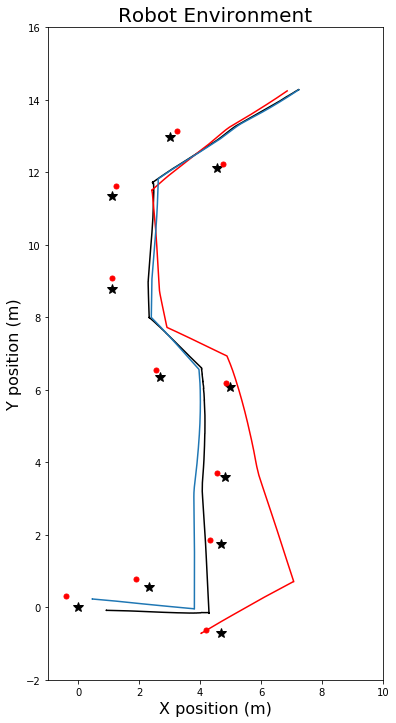

In [6]:
env = plt.figure(figsize=(6, 12))
ax = env.add_subplot(1, 1, 1)
ax.set_xlim((-1, 10))
ax.set_ylim((-2, 16))
ax.set_title("Robot Environment",fontsize=20)
ax.set_xlabel("X position (m)", fontsize=16)
ax.set_ylabel("Y position (m)", fontsize=16)

ax.plot(sim.true_pose[0,:], sim.true_pose[1,:], 'k')
ax.plot(sim.pos_odom_se2[0,:], sim.pos_odom_se2[1,:], 'r')
ax.plot(xhat_robot[0,:], xhat_robot[1,:])
ax.plot(sim.landmarks[0,:], sim.landmarks[1,:], 'k*', markersize=10)
ax.plot(xhat_landmarks[::2,-1], xhat_landmarks[1::2,-1], 'r.', markersize=10)
plt.show()

In [7]:
xhat_landmarks[:,-1]

array([ 4.54654106,  3.69267535,  3.23251947, 13.15346343,  4.332685  ,  1.84721693,  4.19913844, -0.61659504,  1.10846557,  9.07877527,  2.54733701,  6.56155438,  1.24641044, 11.63537622,  4.75662827, 12.22200662,  1.89364944,  0.79446459,  4.83669554,  6.18084384, -0.4094392 ,  0.32357683])

In [8]:
np.diag(unvec(sim.filter.Pvec))

array([0.68862943, 0.65471619, 0.88402158, 0.47499747, 0.56082841, 0.7730697 , 0.49350147, 0.85401313, 0.89013329, 0.46584194, 0.86902877, 0.4812461 , 0.89258611, 0.46567253, 0.86051783, 0.49823234, 0.57298363, 0.5657784 , 0.7782655 , 0.57398619, 0.45909757, 0.75620331, 0.        , 0.        ])

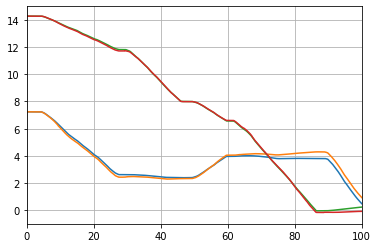

In [9]:
plt.figure()
plt.plot(sim.odom_t, xhat_robot[0,:], sim.odom_t, sim.true_pose[0,:])
plt.plot(sim.odom_t, xhat_robot[1,:], sim.odom_t, sim.true_pose[1,:])
plt.axis([0, 100, -1, 15])
plt.grid()
plt.show()

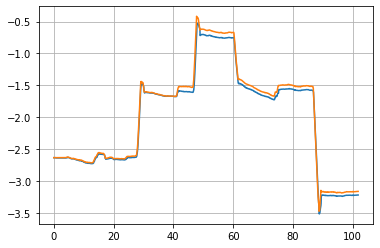

In [10]:
plt.figure()
plt.plot(sim.odom_t,xhat_robot[2,:])
plt.plot(sim.odom_t,sim.true_pose[2,:])
plt.grid()
plt.show()